In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F
%matplotlib inline

In [2]:
with open('../data/RNN_LSTM/AnnaKariennaNovel/anna.txt','r') as f:
    text=f.read()

In [3]:
len(set(text))

83

In [4]:
len(text)

1985223

In [5]:
text[:100]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverythin'

In [6]:
chars=set(text)
int2char = {i:ch for i,ch in enumerate(chars)}
char2int = {ch:i for i,ch in enumerate(chars)}

encoded=np.array([char2int[ch] for ch in text])

In [7]:
encoded.shape

(1985223,)

In [8]:
encoded[:100]

array([34, 25, 50, 14, 41, 15, 75, 33, 80, 32, 32, 32,  9, 50, 14, 14, 57,
       33,  6, 50, 16, 28,  5, 28, 15, 13, 33, 50, 75, 15, 33, 50,  5,  5,
       33, 50,  5, 28, 72, 15, 37, 33, 15, 52, 15, 75, 57, 33, 20, 46, 25,
       50, 14, 14, 57, 33,  6, 50, 16, 28,  5, 57, 33, 28, 13, 33, 20, 46,
       25, 50, 14, 14, 57, 33, 28, 46, 33, 28, 41, 13, 33, 29, 54, 46, 32,
       54, 50, 57, 58, 32, 32,  4, 52, 15, 75, 57, 41, 25, 28, 46])

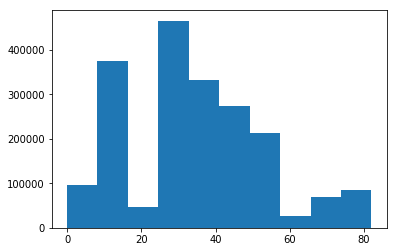

In [9]:
plt.hist(encoded);

In [10]:
''.join(int2char[k] for k in encoded[:100])

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverythin'

In [11]:
def one_hot_encode(arr, n_labels):
    one_hot= np.zeros((np.multiply(*arr.shape),n_labels),dtype=np.float32)
    
    one_hot[np.arange(one_hot.shape[0]),arr.flatten()]=1.
    
    one_hot=one_hot.reshape((*arr.shape,n_labels))
    
    return one_hot

In [12]:
test_seq=np.array([[3,5,1]])
one_hot=one_hot_encode(test_seq,8)
print(one_hot)

[[[0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]]]


In [13]:
def get_batches(arr,batch_size,seq_length):
    
    batch_size_total=batch_size*seq_length
    n_batches=len(arr)//batch_size_total
    
    arr=arr[:n_batches*batch_size_total]
    arr=arr.reshape((batch_size,-1))
    
    for n in range(0,arr.shape[1],seq_length):
        x=arr[:,n:n+seq_length]
        
        y=np.zeros_like(x)
        try:
            y[:,:-1],y[:,-1]=x[:,1:], arr[:,n+seq_length]
        except IndexError:
            y[:,:-1],y[:,-1]=x[:,1:], arr[:,0]
        
        yield x,y

In [14]:
batches=get_batches(encoded,8,50)
x,y=next(batches)

In [15]:
x.shape

(8, 50)

In [16]:
x[:10,:12]

array([[34, 25, 50, 14, 41, 15, 75, 33, 80, 32, 32, 32],
       [13, 29, 46, 33, 41, 25, 50, 41, 33, 50, 41, 41],
       [15, 46, 27, 33, 29, 75, 33, 50, 33,  6, 29, 15],
       [13, 33, 41, 25, 15, 33, 73, 25, 28, 15,  6, 33],
       [33, 13, 50, 54, 33, 25, 15, 75, 33, 41, 15, 50],
       [73, 20, 13, 13, 28, 29, 46, 33, 50, 46, 27, 33],
       [33, 51, 46, 46, 50, 33, 25, 50, 27, 33, 13, 50],
       [74, 70,  5, 29, 46, 13, 72, 57, 58, 33, 49, 79]])

In [17]:
y[:10,:10]

array([[25, 50, 14, 41, 15, 75, 33, 80, 32, 32],
       [29, 46, 33, 41, 25, 50, 41, 33, 50, 41],
       [46, 27, 33, 29, 75, 33, 50, 33,  6, 29],
       [33, 41, 25, 15, 33, 73, 25, 28, 15,  6],
       [13, 50, 54, 33, 25, 15, 75, 33, 41, 15],
       [20, 13, 13, 28, 29, 46, 33, 50, 46, 27],
       [51, 46, 46, 50, 33, 25, 50, 27, 33, 13],
       [70,  5, 29, 46, 13, 72, 57, 58, 33, 49]])

In [18]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print("Training on GPU")
else:
    print("Training on CPU")
    

Training on CPU


In [31]:
class CharRNN(nn.Module):
    def __init__(self,tokens, n_hidden=256, n_layers=2,
                drop_prob=0.5,lr=0.001):
        super().__init__()
        self.drop_prob=drop_prob
        self.n_layers=n_layers
        self.n_hidden=n_hidden
        self.lr=lr
        
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch : ii for ii,ch in self.int2char.items()}
        
        self.LSTM = nn.LSTM(input_size=len(self.chars),hidden_size=self.n_hidden,
                           num_layers=self.n_layers,batch_first=True,
                           dropout=drop_prob)
        self.dropout = nn.Dropout(drop_prob)
        
        self.fc = nn.Linear(n_hidden,len(self.chars))

    def forward(self,x,hidden):
        
        r_output,hidden=self.LSTM(x,hidden)
        out=self.dropout(r_output)
        
        out=out.contiguous().view(-1,self.n_hidden)
        out=self.fc(out)
        
        return out,hidden
    
    def init_hidden(self,batch_size):
        
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden

In [34]:
def train(net, data, epochs=10, batch_size=10, seq_length=50, lr=0.001, clip=5, val_frac=0.1, print_every=10):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        seq_length: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        print_every: Number of steps for printing training and validation loss
    
    '''
    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    if(train_on_gpu):
        net.cuda()
    
    counter = 0
    n_chars = len(net.chars)
    for e in range(epochs):
        # initialize hidden state
        h = net.init_hidden(batch_size)
        
        for x, y in get_batches(data, batch_size, seq_length):
            counter += 1
            
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            if(train_on_gpu):
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()
            
            # get the output from the model
            output, h = net(inputs, h)
            
            # calculate the loss and perform backprop
            loss = criterion(output, targets.view(batch_size*seq_length))
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
            
            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                for x, y in get_batches(val_data, batch_size, seq_length):
                    # One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])
                    
                    inputs, targets = x, y
                    if(train_on_gpu):
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, targets.view(batch_size*seq_length))
                
                    val_losses.append(val_loss.item())
                
                net.train() # reset to train mode after iterationg through validation data
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))

In [32]:
n_hidden=512
n_layers=2

model=CharRNN(chars,n_hidden=n_hidden,n_layers=n_layers)
print(model)

CharRNN(
  (LSTM): LSTM(83, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=512, out_features=83, bias=True)
)


In [35]:
batch_size=128
seq_length=100

n_epochs=20

train(model,data=encoded,epochs=n_epochs,batch_size=batch_size,seq_length=seq_length,lr=0.001)

Epoch: 1/20... Step: 10... Loss: 3.1495... Val Loss: 3.1204
Epoch: 1/20... Step: 20... Loss: 3.1049... Val Loss: 3.1154
Epoch: 1/20... Step: 30... Loss: 3.1098... Val Loss: 3.1053
Epoch: 1/20... Step: 40... Loss: 5.5461... Val Loss: 3.1724
Epoch: 1/20... Step: 50... Loss: 3.1056... Val Loss: 3.0904
Epoch: 1/20... Step: 60... Loss: 3.0547... Val Loss: 3.0509
Epoch: 1/20... Step: 70... Loss: 2.9821... Val Loss: 2.9749
Epoch: 1/20... Step: 80... Loss: 2.9022... Val Loss: 2.8888
Epoch: 1/20... Step: 90... Loss: 2.7843... Val Loss: 2.7760
Epoch: 1/20... Step: 100... Loss: 2.6885... Val Loss: 2.6424
Epoch: 1/20... Step: 110... Loss: 2.6003... Val Loss: 2.5729
Epoch: 1/20... Step: 120... Loss: 2.5410... Val Loss: 2.5209
Epoch: 1/20... Step: 130... Loss: 2.5233... Val Loss: 2.4787
Epoch: 2/20... Step: 140... Loss: 2.4783... Val Loss: 2.4403
Epoch: 2/20... Step: 150... Loss: 2.4469... Val Loss: 2.4137
Epoch: 2/20... Step: 160... Loss: 2.4171... Val Loss: 2.3801
Epoch: 2/20... Step: 170... Loss:

KeyboardInterrupt: 

In [36]:
def predict(net, char, h=None, top_k=None):
        ''' Given a character, predict the next character.
            Returns the predicted character and the hidden state.
        '''
        
        # tensor inputs
        x = np.array([[net.char2int[char]]])
        x = one_hot_encode(x, len(net.chars))
        inputs = torch.from_numpy(x)
        
        if(train_on_gpu):
            inputs = inputs.cuda()
        
        # detach hidden state from history
        h = tuple([each.data for each in h])
        # get the output of the model
        out, h = net(inputs, h)

        # get the character probabilities
        p = F.softmax(out, dim=1).data
        if(train_on_gpu):
            p = p.cpu() # move to cpu
        
        # get top characters
        if top_k is None:
            top_ch = np.arange(len(net.chars))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()
        
        # select the likely next character with some element of randomness
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
        
        # return the encoded value of the predicted char and the hidden state
        return net.int2char[char], h

In [37]:

def sample(net, size, prime='The', top_k=None):
        
    if(train_on_gpu):
        net.cuda()
    else:
        net.cpu()
    
    net.eval() # eval mode
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = predict(net, ch, h, top_k=top_k)

    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for ii in range(size):
        char, h = predict(net, chars[-1], h, top_k=top_k)
        chars.append(char)

    return ''.join(chars)

In [39]:
print(sample(model, 1000, prime='Anna', top_k=5))

Annatisile the wherd thet of
the thith wand she solted, and to the torly to horsing on what hit andat he soun hid sishisgered ancoret has some soudstiste afdesterithy."

That wing hed so to gount whre was thetere wat thet tound ontthit woring the wad and andederen te hit southe the sadtiting thet houds, thet
wong ontit hound.

I has as wothin wes her and oushy shouns to
he tat ant tho se thaned hed was thas.
"" ote an with, and there to her homer ound on the well and the then thens onttey of the part ont the gad thas
hits thing with the thet of
onte ater onge hars thit worle then shith al teres tele to to shas ant an and of the wered, her serand tot hith this he with had he wele was the chong serting werled on thens and oushen aly ofthis wond atery him whe han ang ald ot the ghe sisted, thas hing ther tho se soud to and than he cand and
sor hy with tall to
hind."

Antely
Anthe casting atte sititis oftaring tised
ot and her hed soutell, sherisgeded hes thime thenst of thit he tho catere